In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
import numpy as np
from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt
import pandas as pd

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
df = pd.read_csv('Microsoft_Stock.csv.xls')
df.head(8)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692


Text(0.5, 1.0, 'Stock Price of Microsoft over the Years')

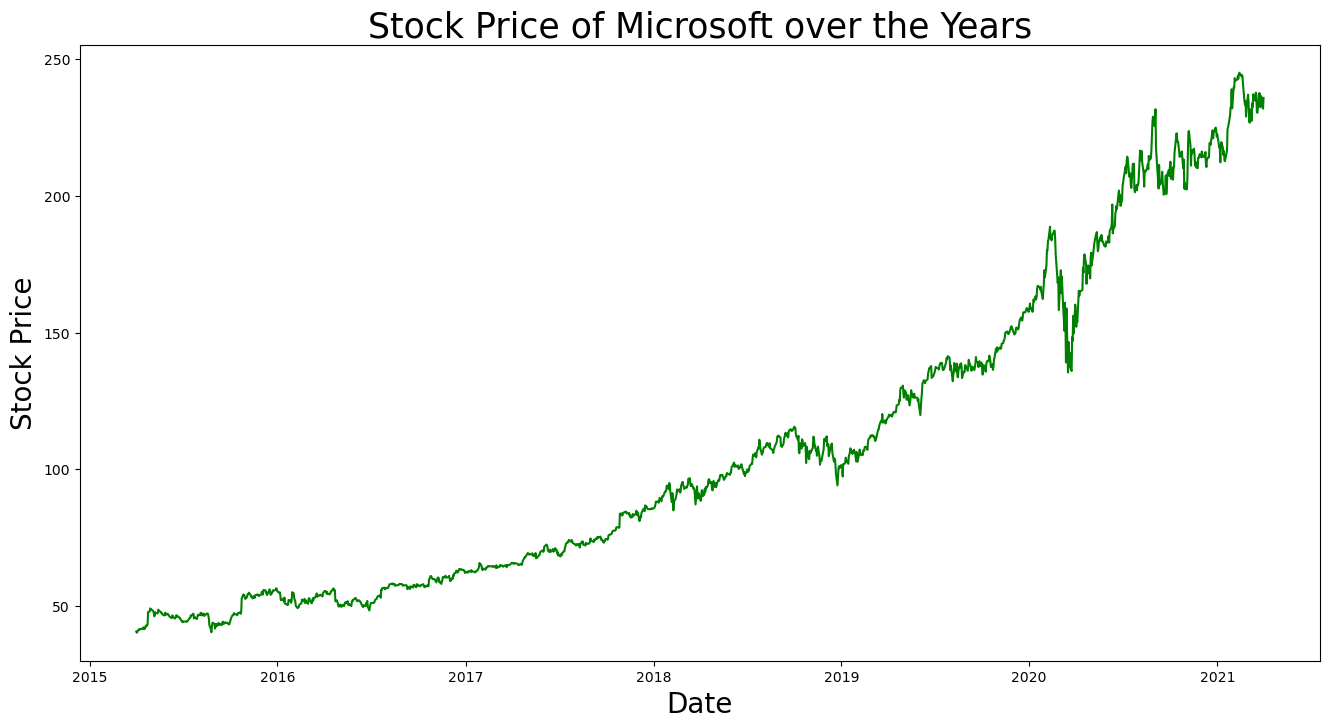

In [3]:
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y %H:%M:%S')
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft over the Years',size=25)

In the upcoming sections, we will explore these variables and use different techniques to predict the daily closing price of the stock.

## Moving Average

#### Introduction

‘Average’ is easily one of the most common things we use in our day-to-day lives. For instance, calculating the average marks to determine overall performance, or finding the average temperature of the past few days to get an idea about today’s temperature – these all are routine tasks we do on a regular basis. So this is a good starting point to use on our dataset for making predictions.

The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set. Here is a simple figure that will help you understand this with more clarity.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/stock8.png)

We will implement this technique on our dataset. The first step is to create a dataframe that contains only the Date and Close price columns, then split it into train and validation sets to verify our predictions.

 

In [4]:
def moving_avg_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    for i in range(0,valid_set.shape[0]):
        a = train_set['Close'][len(train_set)-valid_set.shape[0]+i:].sum() + sum(preds)
        b = a/(valid_set.shape[0])
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Moving Averages',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 76.62376749929759
-----------------------------------------------------------
-----------------------------------------------------------


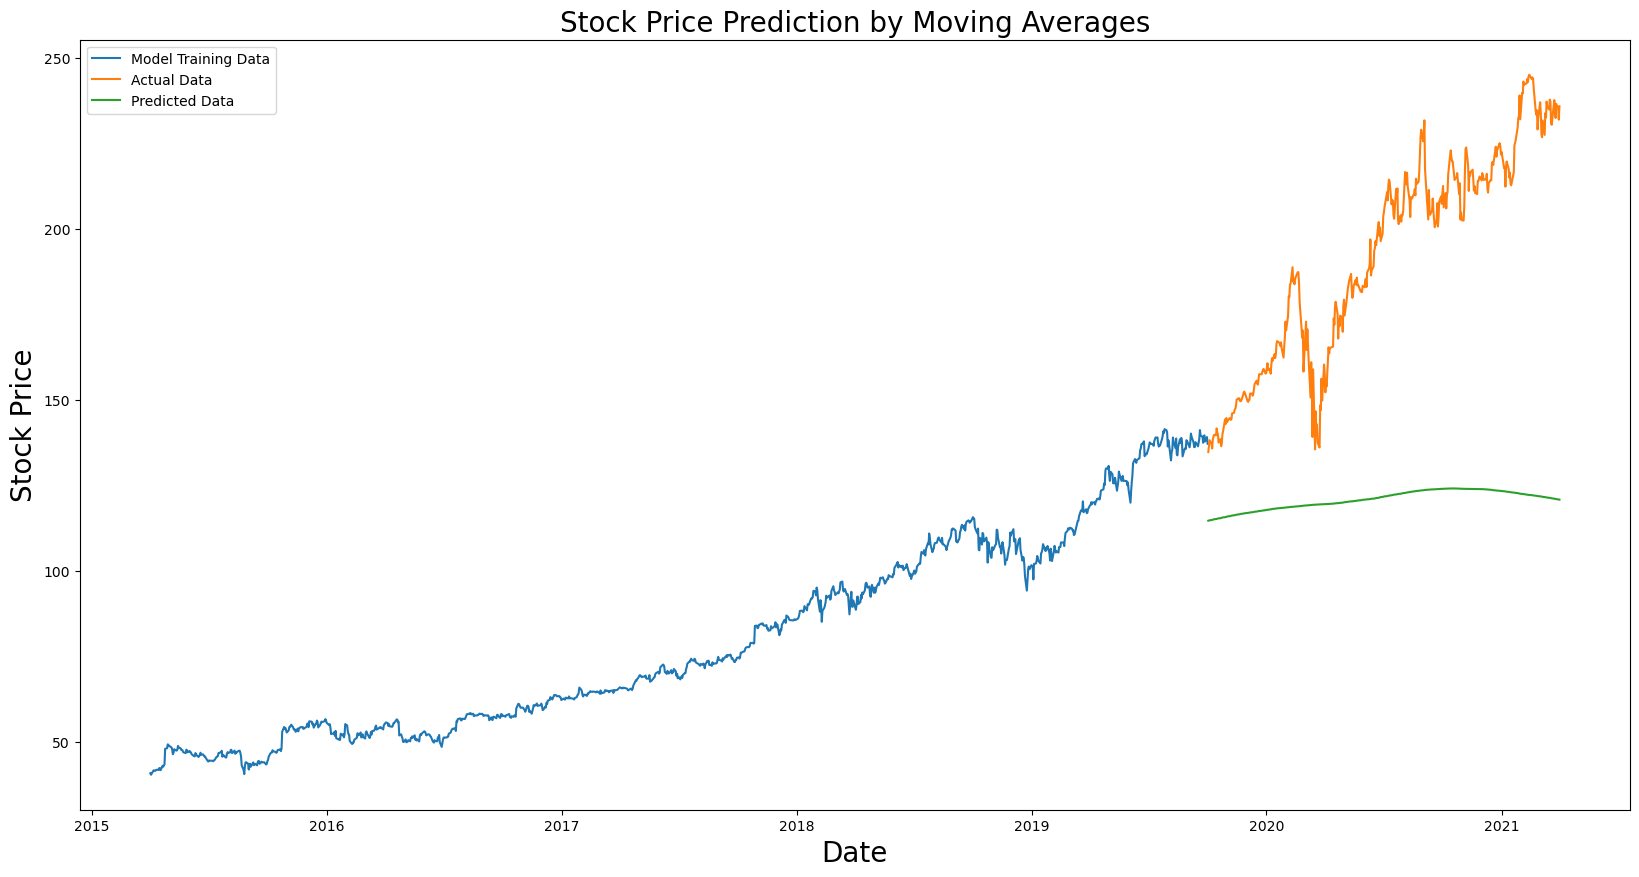

In [5]:
moving_avg_prediction(df)

In [6]:
def linear_regression_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-----------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------')
    print('-----------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    #implement linear regression
    model = LinearRegression()
    model.fit(np.array(x_train).reshape(-1,1),y_train)
    preds = model.predict(np.array(x_valid).reshape(-1,1))
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-preds),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Linear Regression',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LINEAR REGRESSION-----------
-----------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 58.36609230803291
-----------------------------------------------------------
-----------------------------------------------------------


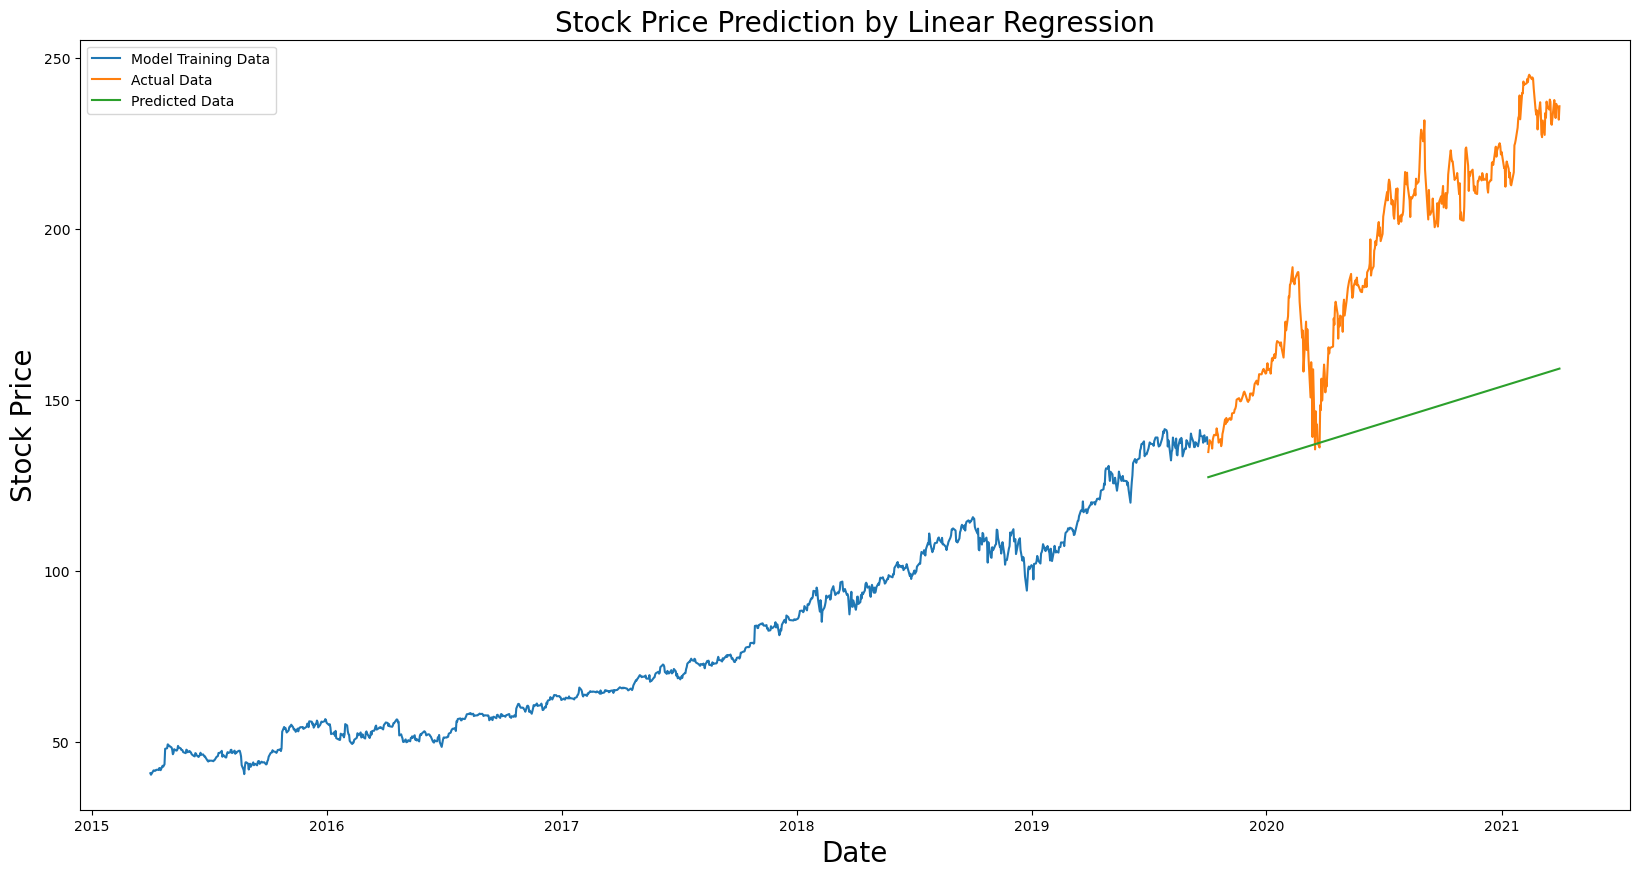

In [7]:
linear_regression_prediction(df)

In [8]:
def k_nearest_neighbours_predict(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('-------------------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train=train_set.reset_index()
    valid=valid_set.reset_index()
    x_train = train['Date'].map(dt.datetime.toordinal)
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)
    y_valid = valid[['Close']]
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = preds
    plt.plot(train_set['Close'])
    plt.plot(valid_set[['Close', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY K-NEAREST NEIGHBORS-----------
-------------------------------------------------------------------
Shape of Training Set (1134, 1)
Shape of Validation Set (377, 1)
RMSE value on validation set: 112.9467566922719
-----------------------------------------------------------
-----------------------------------------------------------


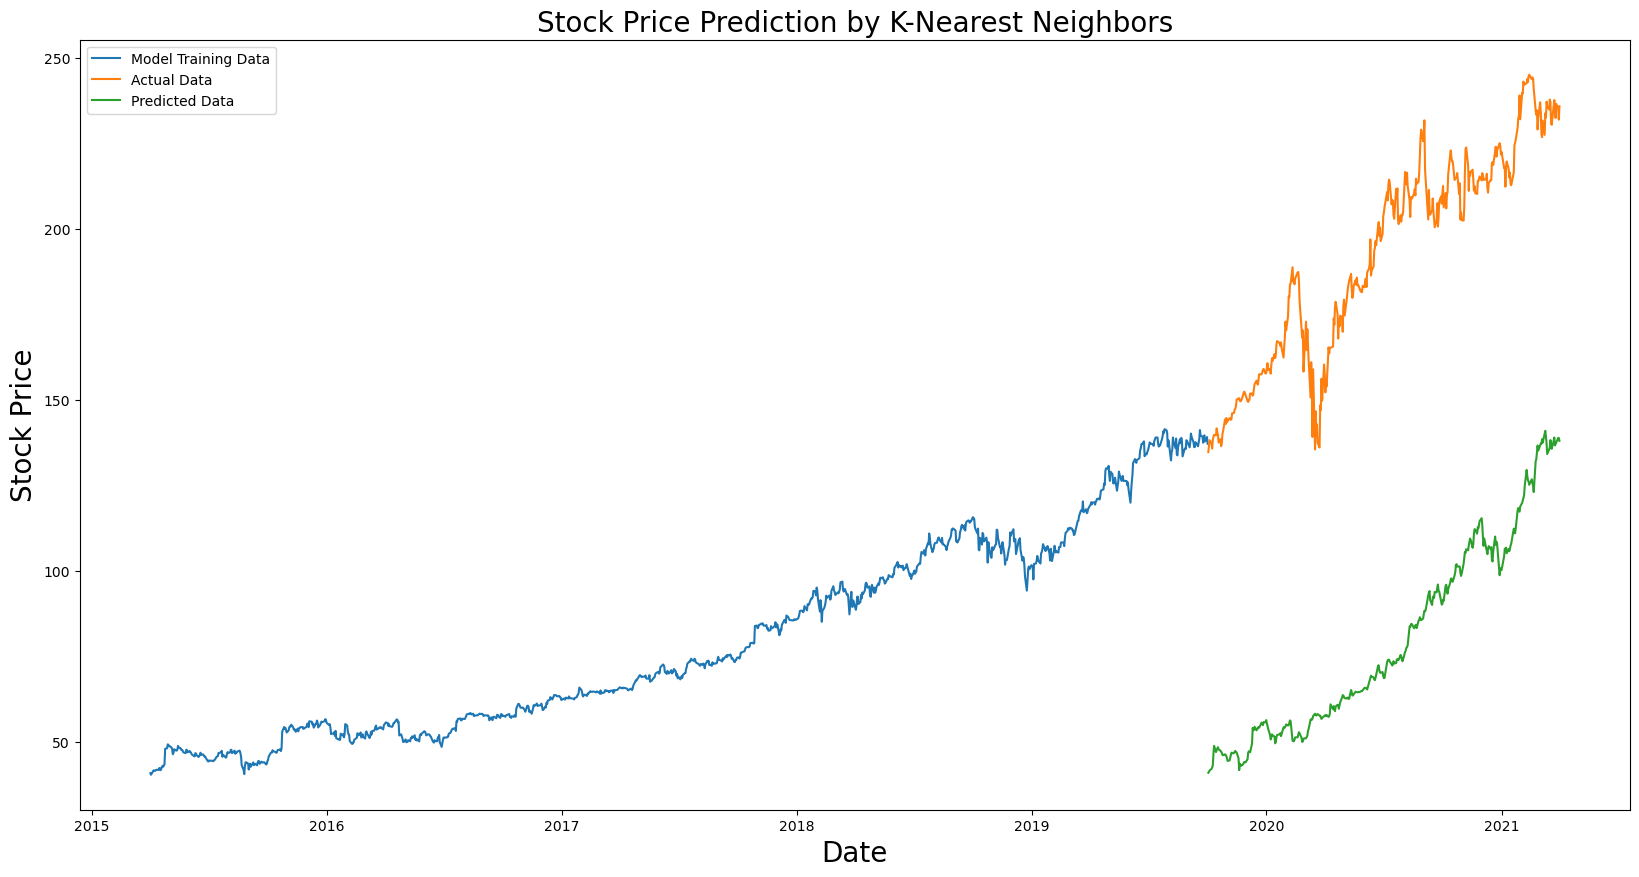

In [9]:
k_nearest_neighbours_predict(df)

In [10]:
def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Close']
    validation = valid_set['Close']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1134, 6)
Shape of Validation Set (377, 6)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4440.431, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4126.393, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4427.420, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3999.903, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4015.175, Time=0.35 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3983.513, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4107.542, Time=0.23 se

/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE value on validation set: nan
-----------------------------------------------------------
-----------------------------------------------------------


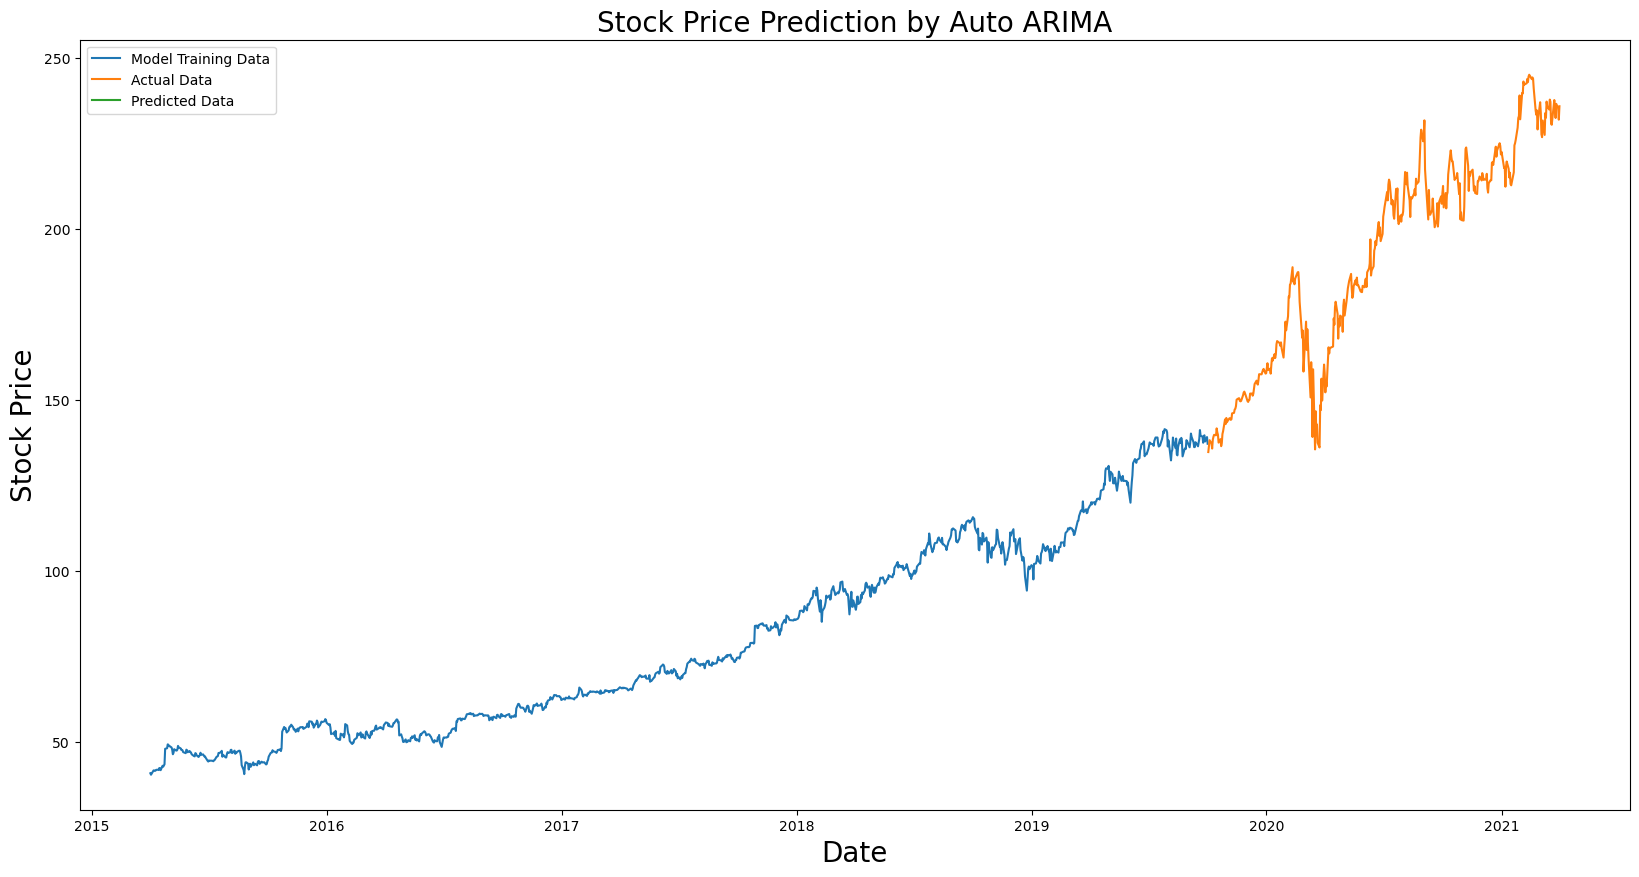

In [11]:
auto_arima_prediction(df)

In [15]:
pip install prophet


  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c4/ef/c7a0349eec94535d37498a06c033dab2793fdfd7751d461ea3a47f4d23af/prophet-1.1.5-py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/3e/bc/0be65769bf0fbcc07147b61f0feeca090f1d321f02df83bd0c4a83ecb642/cmdstanpy-1.2.3-py3-none-any.whl.metadata
  Obtaining dependency information for holidays>=0.25 from https://files.pythonhosted.org/packages/42/12/22bead48246046529afec12833537d6fc99dee47e7432f6f290933d26c32/holidays-0.50-py3-none-any.whl.metadata
  Using cached holidays-0.50-py3-none-any.whl.metadata (23 kB)
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/55/35/076a5ff427a47613581f6bd7acebfa8d49046a1b78132216e26fedee0c6b/stanio-0.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━

In [16]:
from fbprophet import Prophet
def fb_prophet_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.reset_index(inplace=True)
    df_new['Date'] = pd.to_datetime(df_new.Date,format='%Y-%m-%d')
    df_new.index = df_new['Date']
    df_new.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    train_set=df_new.iloc[:ceil(shape*0.75)]
    valid_set=df_new.iloc[ceil(shape*0.75):]
    print('-------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY FB PROPHET-----------')
    print('-------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    model = Prophet()
    model.fit(train_set)
    close_prices = model.make_future_dataframe(periods=len(valid_set))
    forecast = model.predict(close_prices)
    forecast_valid = forecast['yhat'][ceil(shape*0.75):]
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['y'])-np.array(forecast_valid)),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid_set['Predictions'] = forecast_valid.values
    plt.plot(train_set['y'])
    plt.plot(valid_set[['y', 'Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by FB Prophet',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

ModuleNotFoundError: No module named 'fbprophet'

In [17]:
pip install fbprophet


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for cmdstanpy==0.9.5 from https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl.metadata
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for pystan>=2.14 from https://files.pythonhosted.org/packages/20/e7/726e923d328524d0151080f5a1d20f57a025b6d2f72a252c2d2d7abe57f9/pystan-3.9.1-py3-none-any.whl.metadata
  Using cached pystan-3.9.1-py3-none-any.whl.metadata (3.7 kB)
  Obtaining dependency information for LunarCalendar>=0.0.9 from https://files.pythonhosted.org/packages/ab/e0/a52ffc02395474858552ca6437226e23ad67e25fd85cb387f02e479cfe01/LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Obtaining dependency information for convertdate>=2.1.2 from https://file

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
Using cached ephem-4.1.5-cp311-cp311-macosx_11_0_arm64.whl (1.4 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [58 lines of output]
      /private/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/pip-install-frnw05q5/fbprophet_d17edccd8ef64666bb5bac640caf9dd5/setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import (
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib
      creating build/lib/fbprophet
      creating build/l

In [13]:
fb_prophet_prediction(df)

-------------------------------------------------------
-----------STOCK PRICE PREDICTION BY FB PROPHET-----------
-------------------------------------------------------
Shape of Training Set (1134, 2)
Shape of Validation Set (377, 2)


NameError: name 'Prophet' is not defined

In [ ]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

In [ ]:
lstm_prediction(df)